<a href="https://colab.research.google.com/github/Asgil/ES_test_case/blob/main/EpidemicSound_test_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As the first step we want to evaluate the current conversion rates for the funnel.

We begin by loading the data to Pandas.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
def fraction_of_day_to_time(fraction):
    total_seconds = fraction * 86400

    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)

    return f"{hours} hours, {minutes} minutes, {seconds} seconds"

In [3]:
subscriptions = pd.read_csv('subscriptions.csv')
traffic = pd.read_csv('traffic.csv')
users = pd.read_csv('users.csv')

Now we want to know the current conversion rates:
- visitors to users
- users to subscribers

First lets calculate the visitorsto users conversion.

Both visitors and users have matching `cookie_id`.

In [10]:
user_subscriptions = pd.merge(users, subscriptions, on='user_id', how='inner')
paid_subscribers = user_subscriptions[user_subscriptions['did_succeed_first_payment'] == True]
converted_traffic_free = pd.merge(traffic, user_subscriptions, on='cookie_id', how='inner')
converted_traffic_paid = pd.merge(traffic, paid_subscribers, on='cookie_id', how='inner')

total_visitors = traffic['cookie_id'].nunique()

unique_converted_users = converted_traffic_free['cookie_id'].nunique()
unique_paid_subscribers = converted_traffic_paid['cookie_id'].nunique()

conversion_rate_free = (unique_converted_users / total_visitors) * 100
conversion_rate_paid = (unique_paid_subscribers / total_visitors) * 100

print(f"Total unique visitors: {total_visitors}")
print(f"Unique converted users (free): {unique_converted_users}")
print(f"Unique paid subscribers: {unique_paid_subscribers}")
print(f"Conversion rate to free users: {conversion_rate_free:.2f}%")
print(f"Conversion rate to paid subscribers from visitors: {conversion_rate_paid:.2f}%")

Total unique visitors: 1410562
Unique converted users (free): 19635
Unique paid subscribers: 8219
Conversion rate to free users: 1.39%
Conversion rate to paid subscribers from visitors: 0.58%


Now we know the percentage of people signing up for our service.

In [5]:
user_subscriptions = pd.merge(users, subscriptions, on='user_id', how='inner')
converted_traffic_free = pd.merge(traffic, user_subscriptions, on='cookie_id', how='inner')
paid_subscribers = user_subscriptions[user_subscriptions['did_succeed_first_payment'] == True]
converted_traffic_paid = pd.merge(traffic, paid_subscribers, on='cookie_id', how='inner')

total_visitors_per_country = traffic.groupby('country_code')['cookie_id'].nunique().reset_index()
total_visitors_per_country.rename(columns={'cookie_id': 'total_traffic'}, inplace=True)

unique_converted_users_per_country = converted_traffic_free.groupby('country_code')['cookie_id'].nunique().reset_index()
unique_converted_users_per_country.rename(columns={'cookie_id': 'unique_converted_users'}, inplace=True)

unique_paid_subscribers_per_country = converted_traffic_paid.groupby('country_code')['cookie_id'].nunique().reset_index()
unique_paid_subscribers_per_country.rename(columns={'cookie_id': 'unique_paid_subscribers'}, inplace=True)

conversion_rates_by_country = pd.merge(total_visitors_per_country, unique_converted_users_per_country, on='country_code', how='left')
conversion_rates_by_country = pd.merge(conversion_rates_by_country, unique_paid_subscribers_per_country, on='country_code', how='left')

conversion_rates_by_country['conversion_rate_free'] = (conversion_rates_by_country['unique_converted_users'] / conversion_rates_by_country['total_traffic']) * 100
conversion_rates_by_country['conversion_rate_paid'] = (conversion_rates_by_country['unique_paid_subscribers'] / conversion_rates_by_country['total_traffic']) * 100

conversion_rates_by_country[['country_code', 'total_traffic', 'unique_converted_users', 'unique_paid_subscribers', 'conversion_rate_free', 'conversion_rate_paid']]


,country_code,total_traffic,unique_converted_users,unique_paid_subscribers,conversion_rate_free,conversion_rate_paid
0,DE,138445,1628,758,1.175918,0.547510
1,GB,206078,2845,1164,1.380545,0.564835
2,IN,153636,799,198,0.520060,0.128876
3,US,912992,14377,6105,1.574713,0.668681


In [9]:
user_subscriptions = pd.merge(users, subscriptions, on='user_id', how='inner')
converted_traffic_free = pd.merge(traffic, user_subscriptions, on='cookie_id', how='inner')
paid_subscribers = user_subscriptions[user_subscriptions['did_succeed_first_payment'] == True]
converted_traffic_paid = pd.merge(traffic, paid_subscribers, on='cookie_id', how='inner')

total_visitors_per_group = traffic.groupby(['country_code', 'device'])['cookie_id'].nunique().reset_index()
total_visitors_per_group.rename(columns={'cookie_id': 'total_traffic'}, inplace=True)

unique_converted_users_per_group = converted_traffic_free.groupby(['country_code', 'device'])['cookie_id'].nunique().reset_index()
unique_converted_users_per_group.rename(columns={'cookie_id': 'unique_converted_users'}, inplace=True)

unique_paid_subscribers_per_group = converted_traffic_paid.groupby(['country_code', 'device', 'plan', 'list_price', 'billing_frequency'])['cookie_id'].nunique().reset_index()
unique_paid_subscribers_per_group.rename(columns={'cookie_id': 'unique_paid_subscribers'}, inplace=True)

total_paid_subscribers_per_group = converted_traffic_paid.groupby(['country_code'])['cookie_id'].nunique().reset_index()
total_paid_subscribers_per_group.rename(columns={'cookie_id': 'total_paid_subscribers'}, inplace=True)

conversion_rates_by_group = pd.merge(total_visitors_per_group, unique_converted_users_per_group, on=['country_code', 'device'], how='left')
conversion_rates_by_group = pd.merge(conversion_rates_by_group, unique_paid_subscribers_per_group, on=['country_code', 'device'], how='left')
conversion_rates_by_group = pd.merge(conversion_rates_by_group, total_paid_subscribers_per_group, on=['country_code'], how='left')

conversion_rates_by_group['conversion_rate_free'] = (conversion_rates_by_group['unique_converted_users'] / conversion_rates_by_group['total_traffic']) * 100
conversion_rates_by_group['conversion_rate_paid'] = (conversion_rates_by_group['unique_paid_subscribers'] / conversion_rates_by_group['total_traffic']) * 100
conversion_rates_by_group['plan_customer_percentage'] = (conversion_rates_by_group['unique_paid_subscribers'] / conversion_rates_by_group['total_paid_subscribers']) * 100

#conversion_rates_by_group[['country_code', 'device', 'total_traffic', 'unique_converted_users', 'plan', 'list_price', 'billing_frequency', 'unique_paid_subscribers', 'total_paid_subscribers', 'conversion_rate_free', 'conversion_rate_paid', 'plan_customer_percentage']]
conversion_rates_by_group[['country_code', 'device', 'conversion_rate_free', 'conversion_rate_paid']]


,country_code,device,conversion_rate_free,conversion_rate_paid
0,DE,Desktop,1.447370,0.037720
1,DE,Desktop,1.447370,0.075440
2,DE,Desktop,1.447370,0.333014
3,DE,Desktop,1.447370,0.219854
4,DE,Mobile,0.623974,0.017515
5,DE,Mobile,0.623974,0.028462
6,DE,Mobile,0.623974,0.151067
7,DE,Mobile,0.623974,0.109469
8,GB,Desktop,2.087894,0.033141
9,GB,Desktop,2.087894,0.041863


In [ ]:
user_subscriptions = pd.merge(users, subscriptions, on='user_id', how='inner')
converted_traffic_free = pd.merge(traffic, user_subscriptions, on='cookie_id', how='inner')
paid_subscribers = user_subscriptions[user_subscriptions['did_succeed_first_payment'] == True]
converted_traffic_paid = pd.merge(traffic, paid_subscribers, on='cookie_id', how='inner')

total_visitors_per_group = traffic.groupby(['country_code', 'device'])['cookie_id'].nunique().reset_index()
total_visitors_per_group.rename(columns={'cookie_id': 'total_traffic'}, inplace=True)

unique_converted_users_per_group = converted_traffic_free.groupby(['country_code', 'device'])['cookie_id'].nunique().reset_index()
unique_converted_users_per_group.rename(columns={'cookie_id': 'unique_converted_users'}, inplace=True)

unique_paid_subscribers_per_group = converted_traffic_paid.groupby(['country_code', 'device'])['cookie_id'].nunique().reset_index()
unique_paid_subscribers_per_group.rename(columns={'cookie_id': 'unique_paid_subscribers'}, inplace=True)

total_paid_subscribers_per_group = converted_traffic_paid.groupby(['country_code'])['cookie_id'].nunique().reset_index()
total_paid_subscribers_per_group.rename(columns={'cookie_id': 'total_paid_subscribers'}, inplace=True)

conversion_rates_by_group = pd.merge(total_visitors_per_group, unique_converted_users_per_group, on=['country_code', 'device'], how='left')
conversion_rates_by_group = pd.merge(conversion_rates_by_group, unique_paid_subscribers_per_group, on=['country_code', 'device'], how='left')
conversion_rates_by_group = pd.merge(conversion_rates_by_group, total_paid_subscribers_per_group, on=['country_code'], how='left')

conversion_rates_by_group['conversion_rate_free'] = (conversion_rates_by_group['unique_converted_users'] / conversion_rates_by_group['total_traffic']) * 100
conversion_rates_by_group['conversion_rate_paid'] = (conversion_rates_by_group['unique_paid_subscribers'] / conversion_rates_by_group['total_traffic']) * 100
conversion_rates_by_group['conversion_rate_free_to_paid'] = (conversion_rates_by_group['unique_paid_subscribers'] / conversion_rates_by_group['unique_converted_users']) * 100
conversion_rates_by_group['plan_customer_percentage'] = (conversion_rates_by_group['unique_paid_subscribers'] / conversion_rates_by_group['total_paid_subscribers']) * 100

conversion_rates_by_group[['country_code', 'device', 'conversion_rate_free_to_paid']]


,country_code,device,conversion_rate_free_to_paid
0,DE,Desktop,43.382353
1,DE,Mobile,53.125000
2,GB,Desktop,39.919355
3,GB,Mobile,36.363636
4,IN,Desktop,39.130435
5,IN,Mobile,27.272727
6,US,Desktop,46.400000
7,US,Mobile,33.030303


## Average Time to Convert

In [ ]:
first_visit = traffic.assign(date_day=pd.to_datetime(traffic['date_day'])).groupby('cookie_id').agg(first_visit_date=pd.NamedAgg(column='date_day', aggfunc='min')).reset_index()
user_conversion = pd.merge(users.assign(user_creation_dt=pd.to_datetime(users['user_creation_dt'])), first_visit, on='cookie_id', how='inner')

user_conversion['conversion_delay'] = (user_conversion['user_creation_dt'] - user_conversion['first_visit_date']).dt.days

average_conversion_delay = user_conversion['conversion_delay'].mean()
print(fraction_of_day_to_time(average_conversion_delay))

12 hours, 20 minutes, 4 seconds


In [ ]:
subscriptions.head()

,subscription_creation_dt,subscription_id,user_id,plan,billing_frequency,list_price,did_succeed_trial,did_succeed_first_payment
0,2023-10-24,945458aabae,815516f9eea,personal,monthly,10,False,NaN
1,2023-10-24,a441f82b931,85fc533b0ab,personal,yearly,100,False,NaN
2,2023-10-24,14c728d0233,998c9dbe0f6,personal,yearly,100,False,NaN
3,2023-10-24,b442d856a7d,cda9e21cebb,personal,yearly,100,False,NaN
4,2023-10-24,742f3b1bfcd,488febe031c,personal,monthly,10,False,NaN


In [ ]:
traffic.head()

,date_day,cookie_id,device,country_code
0,2023-10-04,af43bbb3c03,Mobile,US
1,2023-10-04,afd6725e965,Mobile,US
2,2023-10-04,41afdcf0822,Mobile,US
3,2023-10-04,3fe4630aff0,Mobile,US
4,2023-10-04,ca5b0aff3c8,Mobile,IN


In [ ]:
users.head()

,user_creation_dt,cookie_id,user_id
0,2023-10-29,eae5d596d51,498d77c12d1
1,2023-10-26,6369ea8fb0e,c5e78a0388c
2,2023-10-27,99563869d88,59716804e10
3,2023-10-26,a0150aa2f7e,ff3dec606ce
4,2023-10-27,2634053e625,d52059b7b3e


In [ ]:
traffic.describe(include='all')

,date_day,cookie_id,device,country_code
count,469196,469196,469196,469195
unique,31,450348,3,4
top,2023-10-03,e078ca365ec,Desktop,US
freq,17862,13,245140,299504


In [ ]:
users.describe(include='all')

,user_creation_dt,cookie_id,user_id
count,58043,58043,58043
unique,31,56818,58043
top,2023-10-30,bfc2c5b44f3,498d77c12d1
freq,2526,22,1


In [ ]:
subscriptions.describe(include='all')

,subscription_creation_dt,subscription_id,user_id,plan,billing_frequency,list_price,did_succeed_trial,did_succeed_first_payment
count,19689,19689,19689,19689,19689,19689.000000,19689,12195
unique,31,19689,19688,2,2,NaN,2,2
top,2023-10-24,945458aabae,652a6888697,personal,monthly,NaN,True,True
freq,768,1,2,17657,11978,NaN,12195,8228
mean,NaN,NaN,NaN,NaN,NaN,51.102138,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,54.665733,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN


In [ ]:
#create a df with a count of users created per date
users_per_date = users.groupby('user_creation_dt').size().reset_index(name='user_count')

In [ ]:
users_per_date.head()

,user_creation_dt,user_count
0,2023-10-01,1798
1,2023-10-02,1915
2,2023-10-03,1973
3,2023-10-04,1978
4,2023-10-05,1853


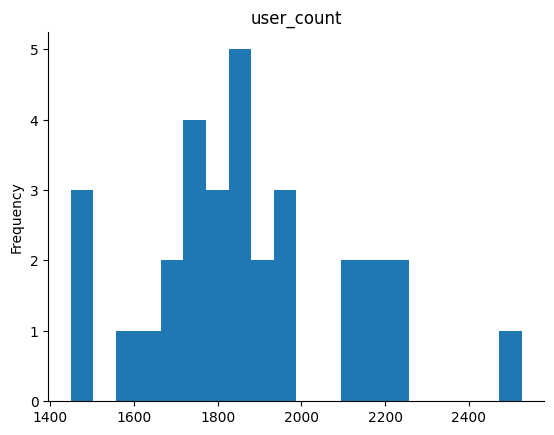

In [ ]:

users_per_date['user_count'].plot(kind='hist', bins=20, title='user_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35')])

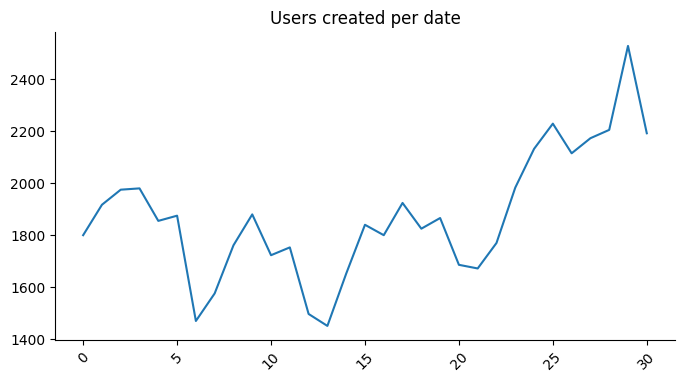

In [ ]:
users_per_date['user_count'].plot(kind='line', figsize=(8, 4), title='Users created per date')

plt.gca().spines[['top', 'right']].set_visible(False)
#set x-axis to show dates
plt.xticks(rotation=45)

In [ ]:
#Fridays, Saturdays drop in users created
#End of October - some sort of promotion?

In [ ]:
#join dataframes users and traffic on cookie_id
merged_data = pd.merge(users, traffic, on='cookie_id', how='inner')

In [ ]:
merged_data.describe(include='all')

,user_creation_dt,cookie_id,user_id,date_day,device,country_code
count,20322,20322,20322,20322,20322,20322
unique,31,18698,19209,31,2,4
top,2023-10-26,bfc2c5b44f3,3a6e53621c0,2023-10-26,Desktop,US
freq,886,66,8,884,13338,13120


In [ ]:
#count cookie_id per date grouped by country and device
traffic_count = traffic.groupby(['date_day', 'country_code', 'device'])['cookie_id'].count().reset_index(name='cookie_count')

In [ ]:
traffic_count.head()

,date_day,country_code,device,cookie_count
0,2023-10-01,DE,Desktop,766
1,2023-10-01,DE,Mobile,425
2,2023-10-01,GB,Desktop,1012
3,2023-10-01,GB,Mobile,826
4,2023-10-01,IN,Desktop,592


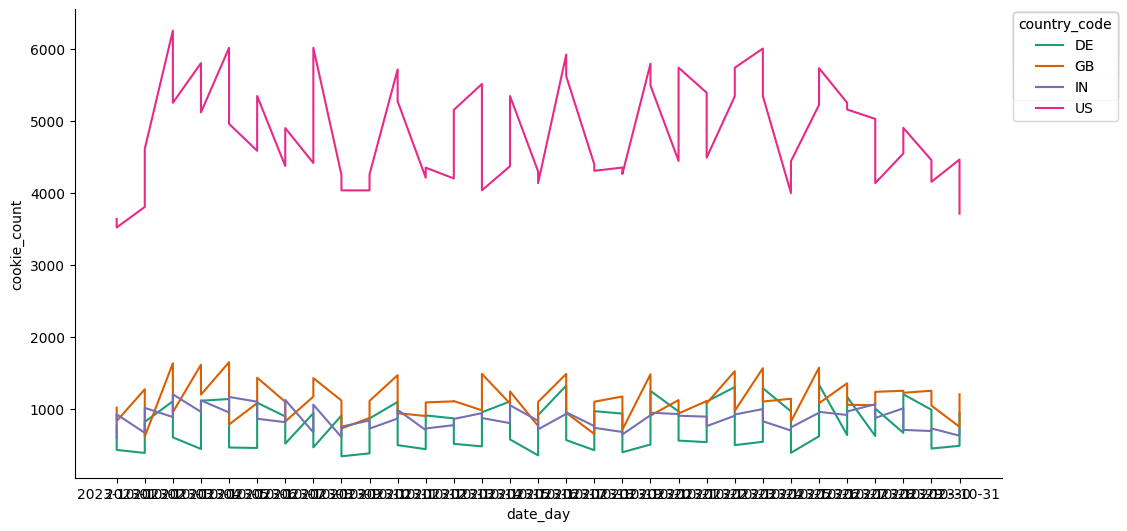

In [ ]:
# @title date_day vs cookie_count

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date_day']
  ys = series['cookie_count']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = traffic_count.sort_values('date_day', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('country_code')):
  _plot_series(series, series_name, i)
  fig.legend(title='country_code', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date_day')
_ = plt.ylabel('cookie_count')

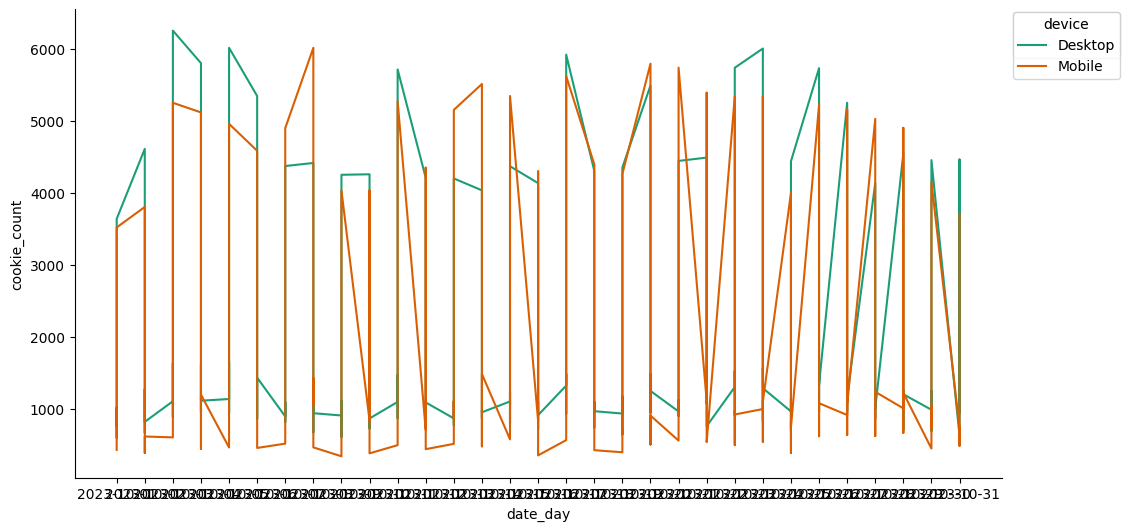

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date_day']
  ys = series['cookie_count']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = traffic_count.sort_values('date_day', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('device')):
  _plot_series(series, series_name, i)
  fig.legend(title='device', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date_day')
_ = plt.ylabel('cookie_count')